# MSD Sorting Initiation

In [1]:
import pandas 
import matplotlib
import matplotlib.pyplot as plt
import openpyxl 
from openpyxl.styles import Color, PatternFill, Font, Border
from openpyxl.formatting.rule import FormatObject, Rule, FormulaRule, CellIsRule
from openpyxl.styles.differential import DifferentialStyle
from openpyxl.drawing.image import Image
import seaborn 
import os
from datetime import datetime

pandas.set_option('display.max_rows', None)
matplotlib.rcParams.update({'savefig.bbox':'tight'})

aboveMessage = 'Above Fit Curve Range'
belowMessage = 'Below Detection Range'


raw = pandas.read_excel('MSD_Analysis_Template.xlsx', sheet_name = '2nd Raw Data', header = 1)

numGroups = len(raw['Sample Group'].unique())
Groups = list(raw['Sample Group'].unique())
numAssays = len(raw['Assay'].unique())
Assays = list(raw['Assay'].unique())

now = datetime.today().strftime('%Y%m%d_%H%M%S')
outfile = 'SortedData'+'_'+str(now)

# Sorting By Sample Then Spot Then Well

In [2]:
iters = 0
groupLengths = []
pandas.DataFrame().to_excel(outfile+'.xlsx')
for b in range(numGroups):
    groupLengths.append(0)
    tempDF = pandas.DataFrame(columns = raw.columns)
    for a in range(len(raw)):
        if raw.loc[a, 'Sample Group'] == Groups[b]:
                tempDF.loc[iters] = raw.loc[a]
                iters = iters +1
    tempDF.sort_values(by = ['Assay', 'Well'], inplace = True)
    Length, width = tempDF.shape
    groupLengths[b] = Length
    with pandas.ExcelWriter(outfile+'.xlsx', mode = 'a', if_sheet_exists = 'replace') as writer:
        tempDF.to_excel(writer, sheet_name = str(Groups[b]), index = False)

# Conditional Formatting

In [3]:
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S','T','U','V', 'W', 'X', 'Y', 'Z']
file = openpyxl.load_workbook(outfile+'.xlsx')
for a in range(len(Groups)):
    ws = file[Groups[a]]
    for b in range(1, groupLengths[a]+2):
        
        if ws['S'+str(b)].value == aboveMessage:
            cell = 'S'+str(b)
            cellrange = 'A1:S'+str(groupLengths[a]+2)
            
            red_text = Font(color="9C0006")
            red_fill = PatternFill(bgColor="FFC7CE")
            red = DifferentialStyle(font=red_text, fill=red_fill)
            
            redrule = Rule(type="containsText", operator="containsText", text='Above', dxf=red)
            redrule.formula = ['NOT(ISERROR(SEARCH("Above", '+cell+')))']
            for eachCol in range(width):
                highlights = str(alphabet[eachCol])+str(b)
                ws.conditional_formatting.add(highlights, redrule)
        if ws['S'+str(b)].value == belowMessage:
            cell = 'S'+str(b)
            cellrange = 'A1:S'+str(groupLengths[a]+2)
            
            blue_text = Font(color = '1271a7')
            blue_fill = PatternFill(bgColor = 'b5e4ea')
            blue = DifferentialStyle(font = blue_text, fill = blue_fill)
            
            bluerule = Rule(type="containsText", operator = 'containsText', text = 'Below', dxf = blue)
            bluerule.formula = ['NOT(ISERROR(SEARCH("Below", '+cell+')))']
            for eachCol in range(width):
                highlights = str(alphabet[eachCol])+str(b)
                ws.conditional_formatting.add(highlights, bluerule)
del file['Sheet1']
file.close()
file.save(outfile+'.xlsx')

# Graphing Data

/Users/labuser/anaconda3/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/labuser/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


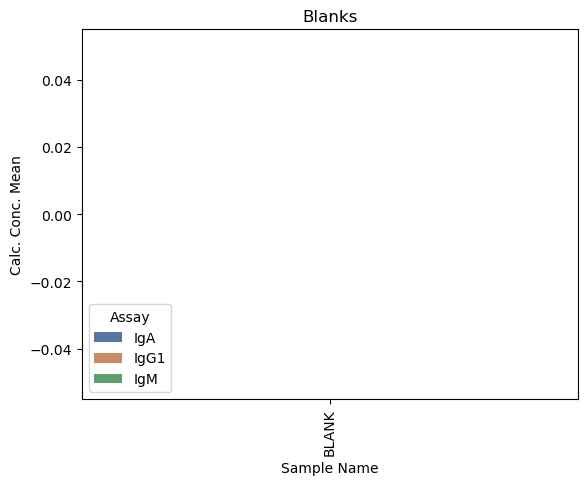

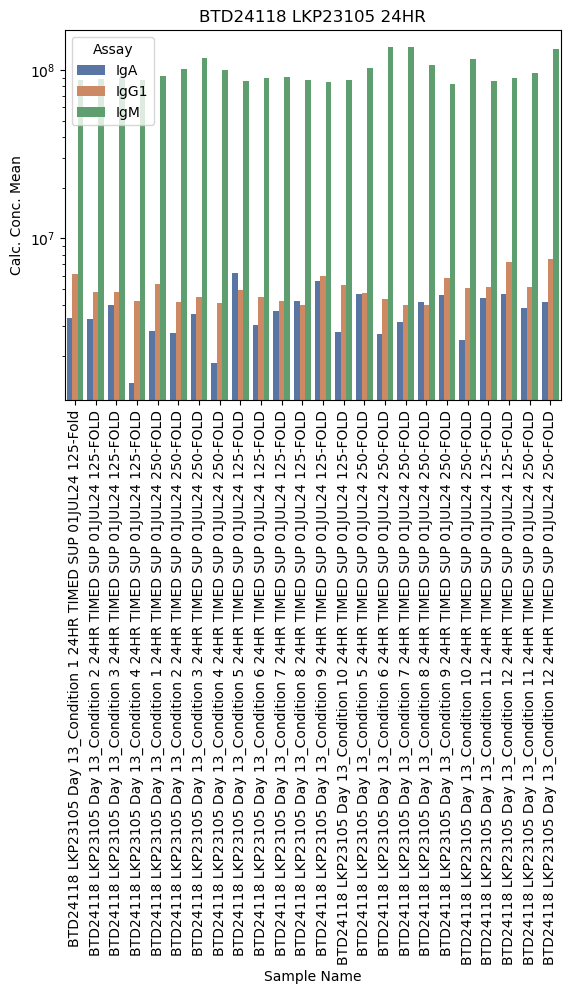

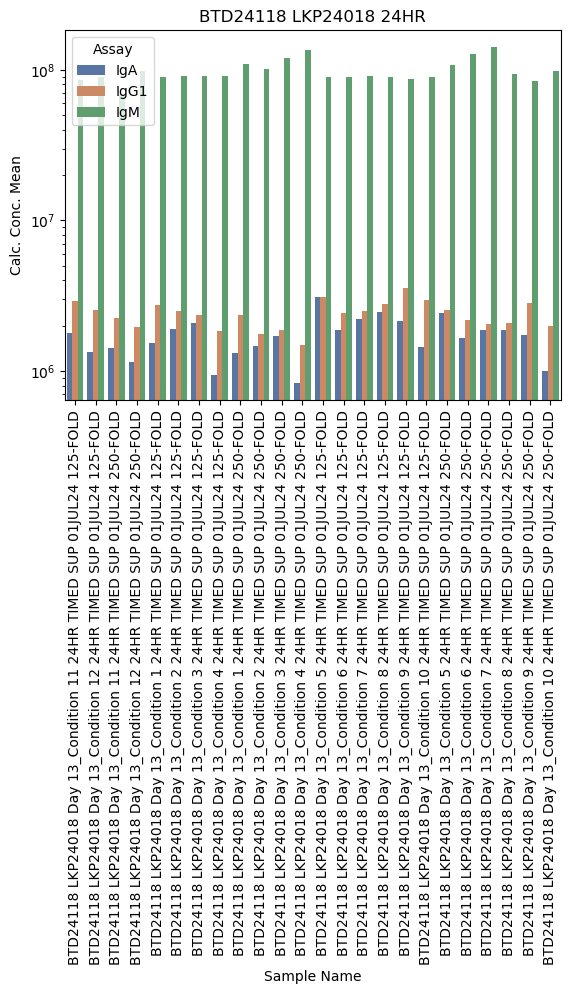

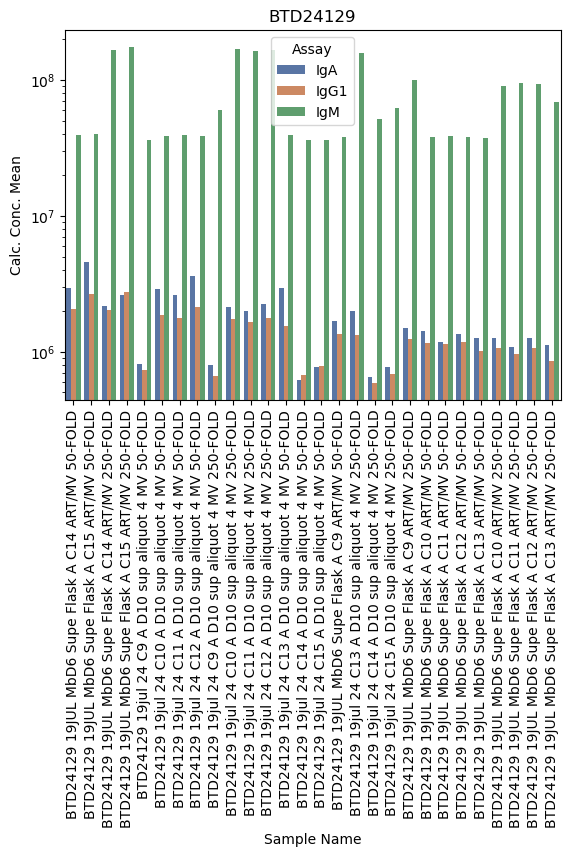

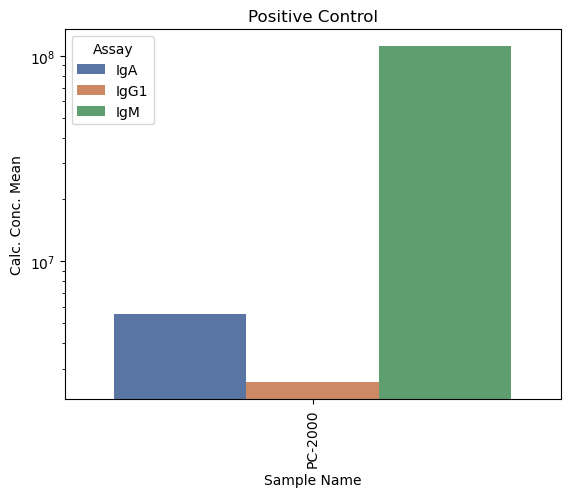

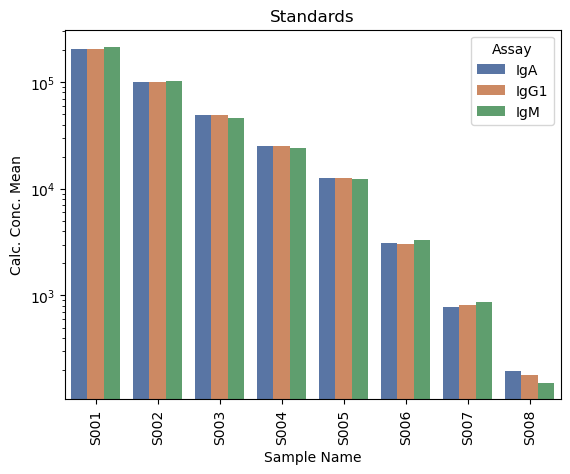

In [7]:
os.makedirs('Graphs', exist_ok = True)
for a in range(len(Groups)):
    file = pandas.read_excel(outfile+'.xlsx', sheet_name = Groups[a])
    groupDF = file[['Sample', 'Assay', 'Dilution', 'Calc. Conc. Mean']]
    plt.figure()
    seaborn.barplot(data = groupDF, x = 'Sample', y = 'Calc. Conc. Mean', hue = 'Assay', palette = 'deep')
    plt.xticks(rotation = 90)
    if groupDF['Calc. Conc. Mean'].sum() == 0:
        plt.yscale('linear')
    else:
        plt.yscale('log')
    plt.savefig('Graphs/'+Groups[a]+'_'+str(now)+'.png')
    plt.title(Groups[a])
    plt.xlabel('Sample Name')
    plt.show()

# Adding Graphs To Excel

In [5]:
wb = openpyxl.load_workbook(outfile+'.xlsx')


#Assign images to import to excel
for a in range(len(Groups)):
    img = Image('Graphs/'+str(Groups[a])+'_'+str(now)+'.png')
    ws = wb[Groups[a]]
    ws.add_image(img, 'V1')
wb.save(outfile+'.xlsx')
